In [69]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

In [70]:
import os
import pandas as pd
import sys
import torch
sys.path.append('../')
sys.path.append('../hms_pipeline')

from hms_pipeline.spec_dataset import SpecDataset, infer_spec_dataset
from hms_pipeline.eeg_model import SpecModel
from hms_pipeline.kaggle_kl_div import eval_subm

In [71]:
import pytorch_lightning as pl
from torch.optim.swa_utils import AveragedModel, get_ema_multi_avg_fn

class EegInferModule(pl.LightningModule):
    def __init__(self, model, config):
        super().__init__()
        self.model = model
        self.config = config
        if config["use_ema"]:
            ema_decay = config["ema_decay"]
            self.ema_model = AveragedModel(model, multi_avg_fn=get_ema_multi_avg_fn(ema_decay))
            print('Using EMA model with decay', ema_decay)
            
    def forward(self, x):
        if self.config["use_ema"]:
            return self.ema_model(x)
        return self.model(x)

In [72]:

model_path = "/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-convnextt-w025-3imgs-kl1-reset/model-f0-val_g10_score=0.3053-val_score=0.5271.ckpt"
config_path = "/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-convnextt-w025-3imgs-kl1-reset/hms-configs.yaml"

model_path = "/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-convnextt-w025-3imgs-reset-fixsize-long05/model-f0-val_g10_score=0.3158-val_score=0.5567.ckpt"
config_path = "/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-convnextt-w025-3imgs-reset-fixsize-long05/hms-configs.yaml"

model_path = "/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-maxvitt-w025-3imgs-kl1-longw/model-f0-val_g10_score=0.3191-val_score=0.5518.ckpt"
config_path = "/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-maxvitt-w025-3imgs-kl1-longw/hms-configs-maxvitt.yaml"

model_path = "/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-convnexts-w025-3imgs-kl1-longw/model-f0-val_g10_score=0.3109-val_score=0.5238.ckpt"
config_path = "/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-convnexts-w025-3imgs-kl1-longw/hms-configs-convnexts.yaml"

model_path = "/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-convnextt-w025-4imgs-kl1/model-f0-val_g10_score=0.3159-val_score=0.5477.ckpt"
config_path = "/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-convnextt-w025-4imgs-kl1/hms-configs-convnextt-4imgs.yaml"

model_path = "/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-convnexts-w025-3imgs-kl1-bandclip-wl200-1e-6/model-f0-val_g10_score=0.3109-val_score=0.5324.ckpt"
config_path = "/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-convnexts-w025-3imgs-kl1-bandclip-wl200-1e-6/hms-configs-convnexts-wl200-1e-6.yaml"

model_path = "/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-maxvitt-w025-3imgs-kl1-bandclip-avgmax/model-f0-val_g10_score=0.3028-val_score=0.5166.ckpt"
config_path = "/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-maxvitt-w025-3imgs-kl1-bandclip-avgmax/hms-configs.yaml"
# model_path = "/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-maxvitt-w025-3imgs-kl1-bandclip-wl200-april/model-f0-val_g10_score=0.3201-val_score=0.5205.ckpt"
# config_path = "/home/maxc/workspace/kaggle-hms/models-hmsv6/hmsv6-maxvitt-w025-3imgs-kl1-bandclip-wl200-april/hms-configs-maxvitt-1e-6.yaml"

model_path = "/home/maxc/workspace/kaggle-hms/models-hmsv6-1/hmsv6-maxvits-4imgs-w025-kl1-512/model-f0-val_g10_score=0.3100-val_score=0.5456.ckpt"
config_path = "/home/maxc/workspace/kaggle-hms/models-hmsv6-1/hmsv6-maxvits-4imgs-w025-kl1-512/hms-configs.yaml"

# model_path = "/home/maxc/workspace/kaggle-hms/models-inference/hmsv6-convnexts-w025-3imgs-kl1-bandclip-wl200-1e-6/model-f0-val_g10_score=0.3109-val_score=0.5324.ckpt"
# config_path = "/home/maxc/workspace/kaggle-hms/models-inference/hmsv6-convnexts-w025-3imgs-kl1-bandclip-wl200-1e-6/hms-configs-convnexts-wl200-1e-6.yaml"
val_df_path = "/home/maxc/workspace/kaggle-hms/folds/val_fold_0.csv"
# val_df_path = "/home/maxc/workspace/kaggle-hms/folds/train_fold_0.csv"
val_df = pd.read_csv(val_df_path)


In [73]:
import yaml
with open(config_path, "r") as f:
    model_config = yaml.load(f, Loader=yaml.FullLoader)
print(model_config)

if model_config["model_type"] == "SpecVitModel":
    model = SpecVitModel(model_config["spec_backbone"], vit_model=model_config["vit_model"], pretrained = False, global_pool=model_config["global_pool"], img_size=model_config["img_size"])
elif model_config["model_type"] == "SpecEegModel":
    print("SpecEegModel")
    model = SpecEegModel(model_config["spec_backbone"], pretrained = False, img_size=model_config["img_size"],dropout=model_config["dropout"])
else:   
    model = SpecModel(model_config["spec_backbone"], pretrained = False, global_pool=model_config["global_pool"], img_size=model_config["img_size"])

# if model_config["use_ema"]:
#     model = AveragedModel(model)

module = EegInferModule(model, model_config)
ckpt = torch.load(model_path)

module.load_state_dict(ckpt['state_dict'], strict=False)
module = module.eval().cuda()
# # print element in state_dict
# for k, v in ckpt['state_dict'].items():
#     print(k)
#     print(v.shape)

{'trainer': {'max_epochs': 12, 'min_epochs': 5, 'enable_progress_bar': True, 'devices': 1, 'deterministic': False, 'precision': '16'}, 'seed': 42, 'patience': 3, 'train_bs': 8, 'valid_bs': 8, 'workers': 8, 'wandb_project': 'hms_v6', 'output_dir': '../models-hmsv6-1/hmsv6-maxvits-4imgs-w025-kl1-512', 'train_folds': [0, 1, 2, 3, 4], 'train_dataset_group': 'unique_label', 'val_dataset_group': 'eeg_id', 'raw_eeg_dir': '/home/maxc/workspace/kaggle-hms/data/v6/raw_eegs_sosbandclip_2500', 'eeg_spec_dir': '/home/maxc/workspace/kaggle-hms/data/v6/eeg_specs_h100w250gf5fft1024wl200lc05_norm_const', 'long_spec_dir': '/home/maxc/workspace/kaggle-hms/data/v6/long_specs', 'l7_weight': 0.25, 'inverse_kl_weight': True, 'inverse_kl_mean': [0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666], 'kl_multiplier': 1.0, 'vote_weight': False, 'img_types': ['long_spec', 'eeg_spec', 'full_raw_eeg', 'raw_eeg'], 'signals': ['LL', 'RL', 'LP', 

In [74]:
# val_dataset = SpecDataset(val_df, eeg_spec_dir, long_spec_dir, raw_eeg_dir, model_config["spec_types"], sub_sample_group=model_config["dataset_group"], train=False)
val_dataset = SpecDataset(val_df,configs = model_config, train = False,)

{'lrflip_prob': 0.0, 'fbflip_prob': 0.0, 'mask_prob': 0.0, 'keep_center_ratio': 0.0, 'hflip_prob': 0.0, 'blur_prob': 0.0, 'roll_prob': 0.0, 'neg_eeg_prob': 0.0, 'contrast_prob': 0.0, 'fuse_prob': 0.0, 'block_prob': 0.0, 'noise_prob': 0.0, 'mask_iter': 5, 'mask_size_ratio': 0.1, 'num_block_ch': 4, 'dummy_votes_prob': 0.0, 'num_dummy_votes': 1}


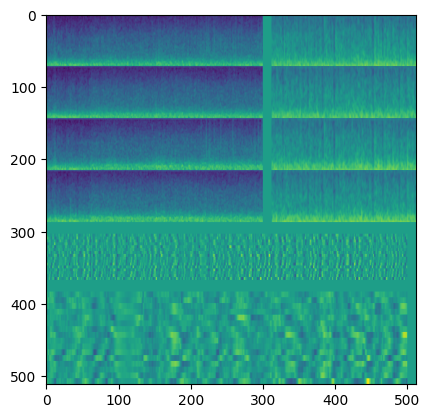

In [75]:

sample = val_dataset[6]
import matplotlib.pyplot as plt
plot = plt.imshow(sample["spec_img"][0].numpy())
sample_img = sample["spec_img"][0].numpy()
plt.show()


plt.show()

In [76]:
# print the attributes of the model
for name, param in module.model.named_parameters():
    print(name, param.shape)
# print(module.model.model.stages[3].blocks[-1])

# model.blocks.4.2.conv_pw.weight torch.Size([720, 120, 1, 1])

model.stem.conv1.weight torch.Size([64, 1, 3, 3])
model.stem.conv1.bias torch.Size([64])
model.stem.norm1.weight torch.Size([64])
model.stem.norm1.bias torch.Size([64])
model.stem.conv2.weight torch.Size([64, 64, 3, 3])
model.stem.conv2.bias torch.Size([64])
model.stages.0.blocks.0.conv.shortcut.expand.weight torch.Size([96, 64, 1, 1])
model.stages.0.blocks.0.conv.shortcut.expand.bias torch.Size([96])
model.stages.0.blocks.0.conv.pre_norm.weight torch.Size([64])
model.stages.0.blocks.0.conv.pre_norm.bias torch.Size([64])
model.stages.0.blocks.0.conv.conv1_1x1.weight torch.Size([384, 64, 1, 1])
model.stages.0.blocks.0.conv.norm1.weight torch.Size([384])
model.stages.0.blocks.0.conv.norm1.bias torch.Size([384])
model.stages.0.blocks.0.conv.conv2_kxk.weight torch.Size([384, 1, 3, 3])
model.stages.0.blocks.0.conv.norm2.weight torch.Size([384])
model.stages.0.blocks.0.conv.norm2.bias torch.Size([384])
model.stages.0.blocks.0.conv.se.fc1.weight torch.Size([24, 384, 1, 1])
model.stages.0.bloc

In [77]:
if model_config["use_ema"]:
    infer_model = module.ema_model.module
else:
    infer_model = module.model

if "efficientnet" in model_config["spec_backbone"]:
    target_layer = infer_model.model.blocks[-1][-1]
elif "convnext" in model_config["spec_backbone"] and model_config["model_type"] == "SpecModel":
    target_layer = infer_model.model.stages[-1].blocks[-1]
elif "maxvit" in model_config["spec_backbone"]:
    target_layer =  infer_model.model.stages[-1].blocks[-1]
elif model_config["model_type"] == "SpecVitModel" and "vit" in model_config["vit_model"]:
    target_layer = infer_model.model.blocks[-1]
print(target_layer)
grad_cam = GradCAM(model=infer_model, target_layers=[target_layer])
# grad_cam = GradCAM(model=module.model, target_layers=[module.model.model.stages[3].blocks[1]])


MaxxVitBlock(
  (conv): MbConvBlock(
    (shortcut): Identity()
    (pre_norm): BatchNormAct2d(
      768, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): Identity()
    )
    (down): Identity()
    (conv1_1x1): Conv2d(768, 3072, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (norm1): BatchNormAct2d(
      3072, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): GELUTanh()
    )
    (conv2_kxk): Conv2d(3072, 3072, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3072, bias=False)
    (norm2): BatchNormAct2d(
      3072, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): GELUTanh()
    )
    (se): SEModule(
      (fc1): Conv2d(3072, 192, kernel_size=(1, 1), stride=(1, 1))
      (bn): Identity()
      (act): SiLU(inplace=True)
      (fc2): Conv2d(192, 3072, kernel_size=(1, 1), stride=(1, 1))
      (gate): Sigmoid()
    )
   

torch.Size([1, 1, 512, 512])
{'eeg_id': 58232455, 'eeg_sub_id': 0, 'eeg_label_offset_seconds': 0.0, 'spectrogram_id': 1622610590, 'spectrogram_sub_id': 0, 'spectrogram_label_offset_seconds': 0.0, 'label_id': 1454727937, 'patient_id': 29534, 'expert_consensus': 'Seizure', 'seizure_vote': 3, 'lpd_vote': 0, 'gpd_vote': 0, 'lrda_vote': 0, 'grda_vote': 0, 'other_vote': 0, 'fold': 0, 'central_id': '58232455_0', 'nonoverlap_eeg_id': '58232455_0', 'unique_label': '58232455_3_0_0_0_0_0', 'unique_id': '58232455_0', 'total_votes': 3, 'kl_div': 1.7917595, 'fused_id': 0}
[1. 0. 0. 0. 0. 0.]
tensor([[0.7999, 0.0210, 0.0382, 0.0279, 0.0433, 0.0697]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor(0.2233, grad_fn=<DivBackward0>)


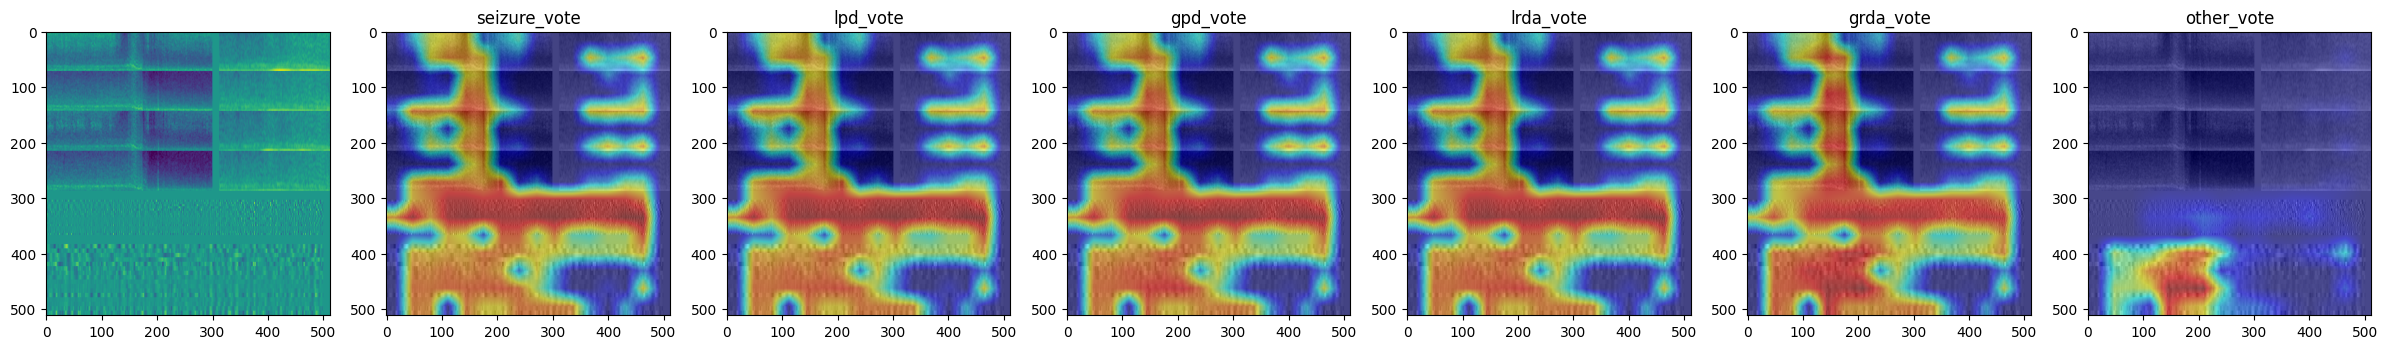

In [78]:
# scale sample_image to 0-1
import matplotlib.pyplot as plt
import torch

num_samples = 3

def display_sample(sample_idx):
    sample = val_dataset[sample_idx]
    # set figure size
    plt.figure(figsize=(30, 10))
    # subplot 1 for the original image
    plt.subplot(1, 7, 1)
    plt.imshow(sample["spec_img"][0].numpy())
    sample_img = sample["spec_img"][0].numpy()
    input_tensor = sample["spec_img"].unsqueeze(0).cuda()
    print(input_tensor.shape)

    TARGETS = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
    classes = len(sample["label"])
    print(sample["metadata"])
    print(sample["label"])
    for i in range(classes):
        target = [ClassifierOutputTarget(i)]
        grayscale_cam = grad_cam(input_tensor=input_tensor, targets=target, eigen_smooth=True)
        grayscale_cam = grayscale_cam[0, :]
        outputs = grad_cam.outputs

        import torch
        kl_loss = torch.nn.KLDivLoss(reduction="batchmean")
        softmax_outputs = torch.log_softmax(outputs, dim=1).cpu()

        loss = kl_loss(softmax_outputs, torch.Tensor(sample["label"]))


        import cv2
        norm_sample_img = (sample_img - sample_img.min()) / (sample_img.max() - sample_img.min())
        # convert norm_sample_img to bgr
        norm_sample_img = norm_sample_img * 255
        norm_sample_img = norm_sample_img.astype('uint8')
        norm_sample_img = cv2.cvtColor(norm_sample_img, cv2.COLOR_GRAY2BGR)
        # plt.subplot(1, 2, 2)
        # plt.imshow(norm_sample_img)
        # plt.show()
        norm_sample_img = (norm_sample_img - norm_sample_img.min()) / (norm_sample_img.max() - norm_sample_img.min())

        visualization = show_cam_on_image(norm_sample_img, grayscale_cam, use_rgb=True)
        plt.subplot(1, 7, 2 + i)
        plt.title(TARGETS[i])
        plt.imshow(visualization)
    print(torch.softmax(outputs, dim=1))
    print(loss)
    plt.show()

display_sample(46)



torch.Size([1, 1, 512, 512])
{'eeg_id': 1809974796, 'eeg_sub_id': 0, 'eeg_label_offset_seconds': 0.0, 'spectrogram_id': 343481994, 'spectrogram_sub_id': 0, 'spectrogram_label_offset_seconds': 0.0, 'label_id': 3896847406, 'patient_id': 36197, 'expert_consensus': 'GPD', 'seizure_vote': 6, 'lpd_vote': 0, 'gpd_vote': 8, 'lrda_vote': 0, 'grda_vote': 0, 'other_vote': 0, 'fold': 0, 'central_id': '1809974796_0', 'nonoverlap_eeg_id': '1809974796_0', 'unique_label': '1809974796_6_0_8_0_0_0', 'unique_id': '1809974796_0', 'total_votes': 14, 'kl_div': 1.1088514, 'fused_id': 0}
[0.42857143 0.         0.5714286  0.         0.         0.        ]
tensor([[0.3591, 0.0141, 0.5825, 0.0012, 0.0020, 0.0412]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor(0.0648, grad_fn=<DivBackward0>)


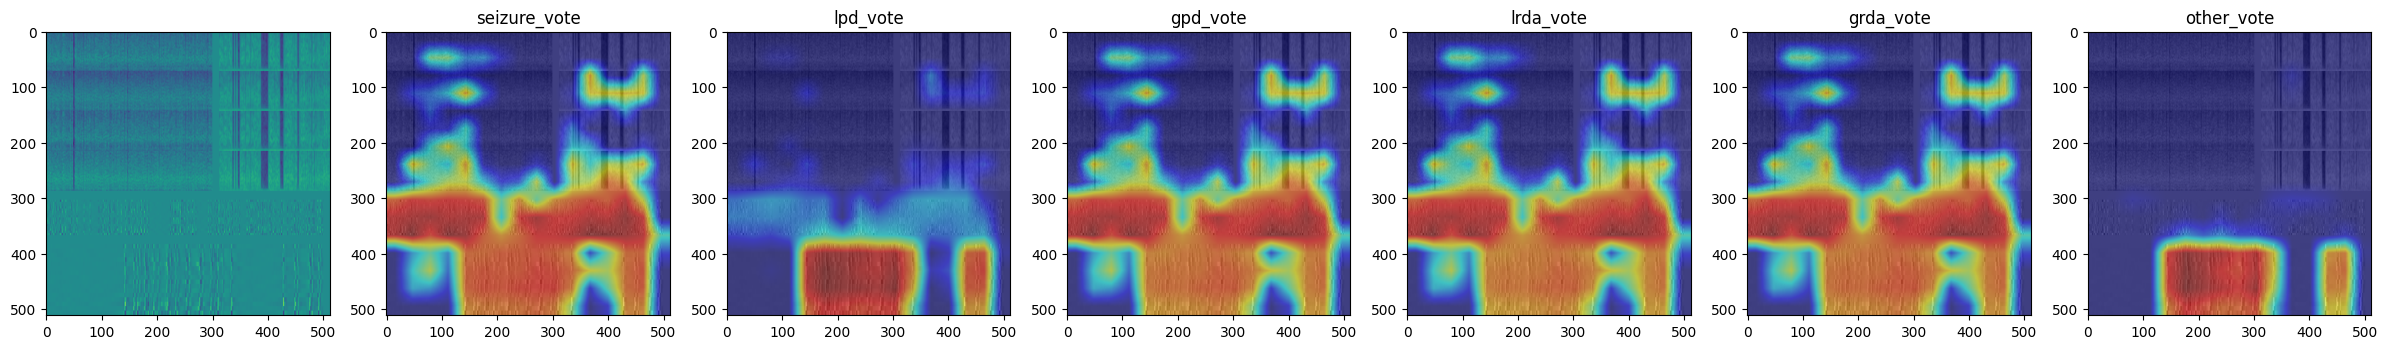

torch.Size([1, 1, 512, 512])
{'eeg_id': 1122004362, 'eeg_sub_id': 0, 'eeg_label_offset_seconds': 0.0, 'spectrogram_id': 1263257641, 'spectrogram_sub_id': 0, 'spectrogram_label_offset_seconds': 0.0, 'label_id': 1139263753, 'patient_id': 26349, 'expert_consensus': 'Other', 'seizure_vote': 0, 'lpd_vote': 0, 'gpd_vote': 0, 'lrda_vote': 1, 'grda_vote': 0, 'other_vote': 2, 'fold': 0, 'central_id': '1122004362_0', 'nonoverlap_eeg_id': '1122004362_0', 'unique_label': '1122004362_0_0_0_1_0_2', 'unique_id': '1122004362_0', 'total_votes': 3, 'kl_div': 1.1552454, 'fused_id': 0}
[0.         0.         0.         0.33333334 0.         0.6666667 ]
tensor([[0.0107, 0.0131, 0.0023, 0.4817, 0.1313, 0.3610]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor(0.2863, grad_fn=<DivBackward0>)


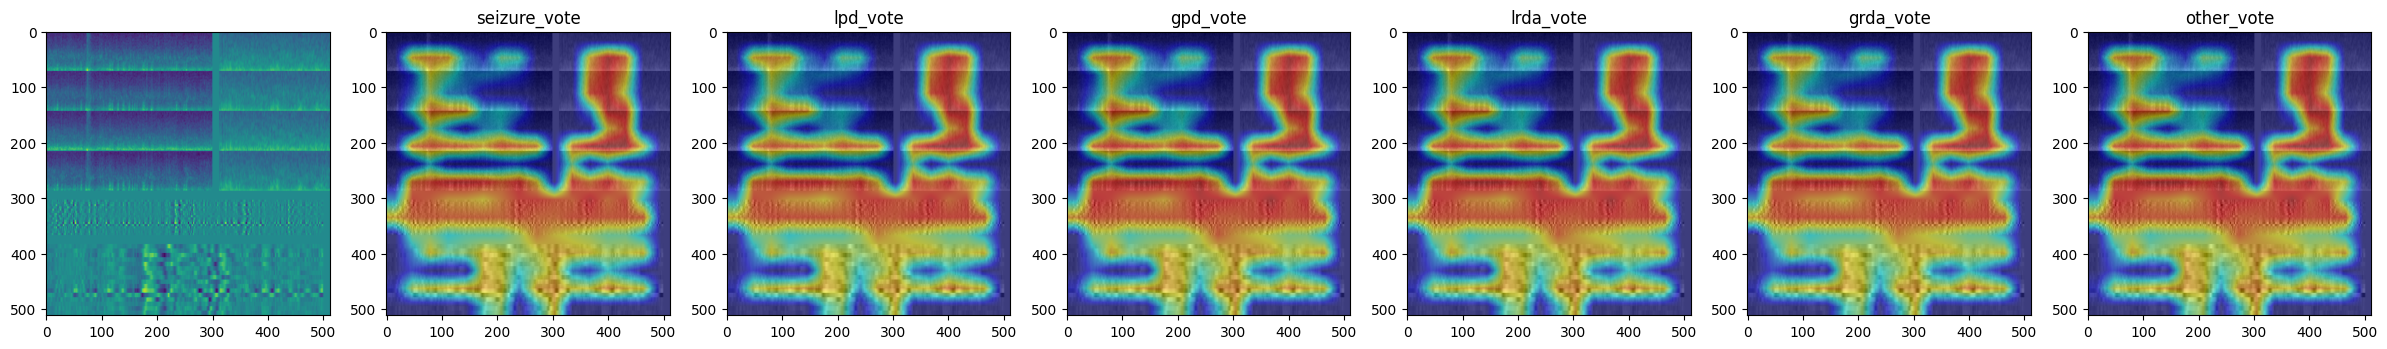

torch.Size([1, 1, 512, 512])
{'eeg_id': 42420127, 'eeg_sub_id': 0, 'eeg_label_offset_seconds': 0.0, 'spectrogram_id': 1697168885, 'spectrogram_sub_id': 1, 'spectrogram_label_offset_seconds': 122.0, 'label_id': 16163814, 'patient_id': 23828, 'expert_consensus': 'Other', 'seizure_vote': 0, 'lpd_vote': 0, 'gpd_vote': 0, 'lrda_vote': 0, 'grda_vote': 0, 'other_vote': 1, 'fold': 0, 'central_id': '42420127_0', 'nonoverlap_eeg_id': '42420127_0', 'unique_label': '42420127_0_0_0_0_0_1', 'unique_id': '42420127_0', 'total_votes': 1, 'kl_div': 1.7917595, 'fused_id': 0}
[0. 0. 0. 0. 0. 1.]
tensor([[0.0032, 0.0034, 0.0015, 0.0135, 0.1006, 0.8778]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor(0.1303, grad_fn=<DivBackward0>)


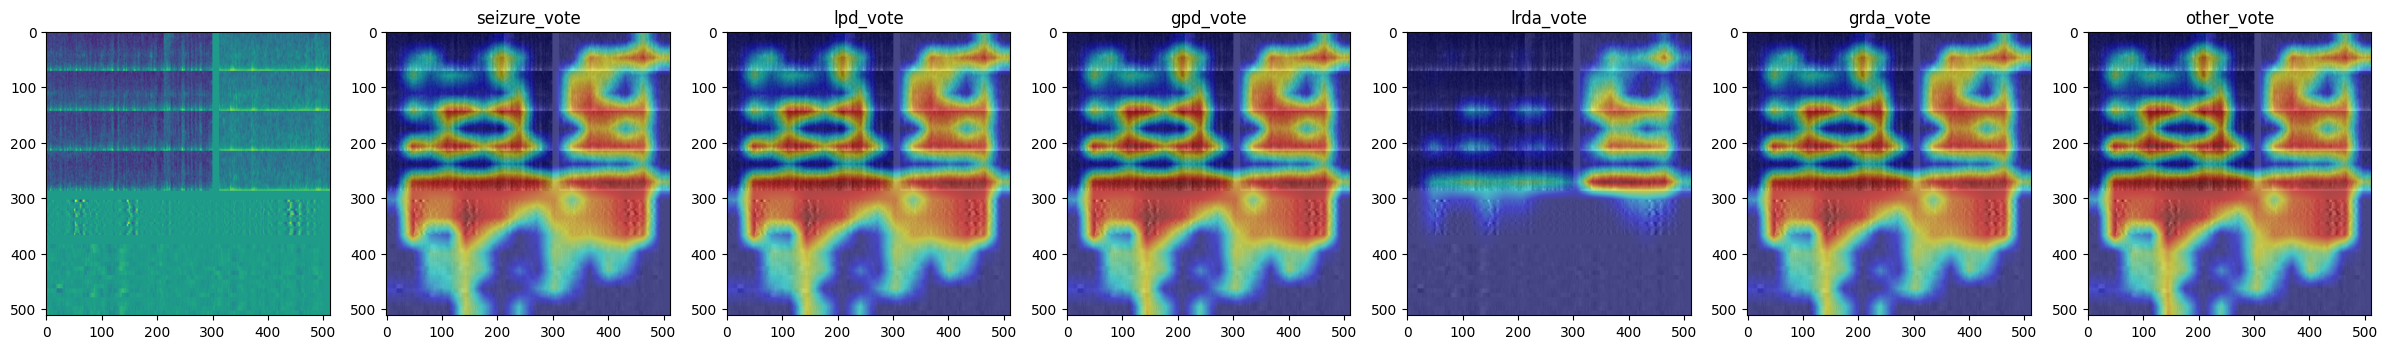

torch.Size([1, 1, 512, 512])
{'eeg_id': 1630916697, 'eeg_sub_id': 0, 'eeg_label_offset_seconds': 0.0, 'spectrogram_id': 602857591, 'spectrogram_sub_id': 2, 'spectrogram_label_offset_seconds': 442.0, 'label_id': 3703057621, 'patient_id': 24432, 'expert_consensus': 'Other', 'seizure_vote': 0, 'lpd_vote': 0, 'gpd_vote': 0, 'lrda_vote': 1, 'grda_vote': 0, 'other_vote': 2, 'fold': 0, 'central_id': '1630916697_0', 'nonoverlap_eeg_id': '1630916697_0', 'unique_label': '1630916697_0_0_0_1_0_2', 'unique_id': '1630916697_0', 'total_votes': 3, 'kl_div': 1.1552454, 'fused_id': 0}
[0.         0.         0.         0.33333334 0.         0.6666667 ]
tensor([[0.0144, 0.0211, 0.0011, 0.1285, 0.0305, 0.8044]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor(0.1925, grad_fn=<DivBackward0>)


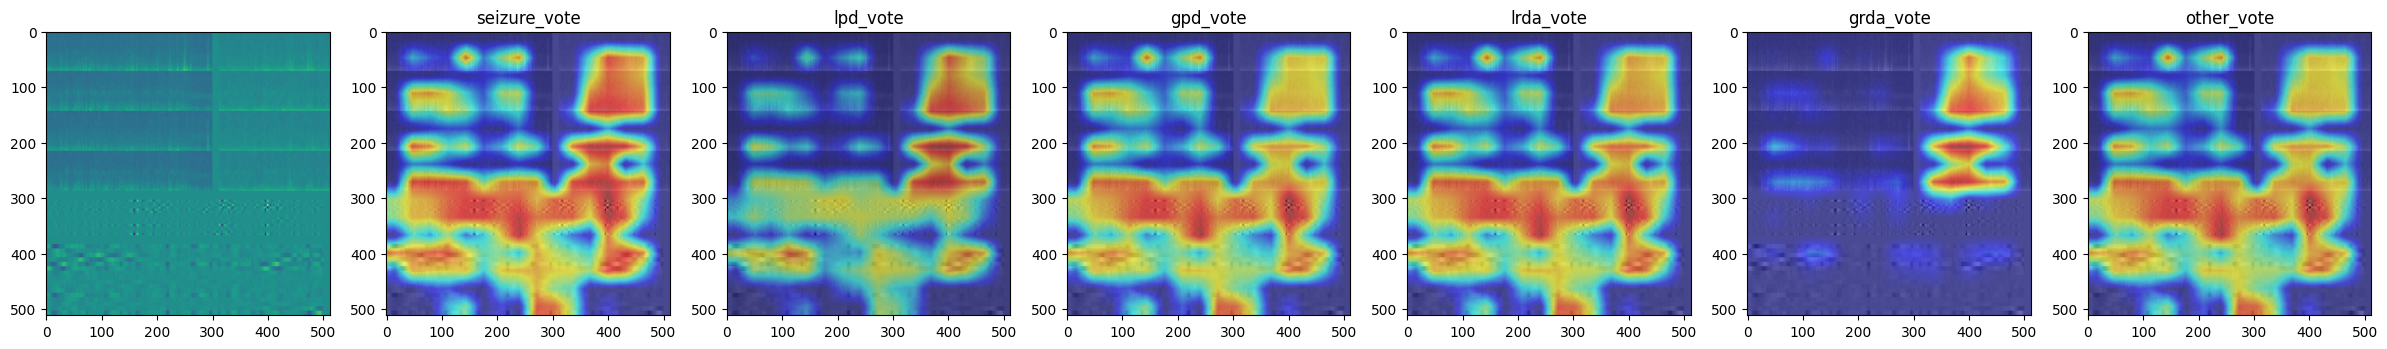

torch.Size([1, 1, 512, 512])
{'eeg_id': 73522966, 'eeg_sub_id': 0, 'eeg_label_offset_seconds': 0.0, 'spectrogram_id': 656700685, 'spectrogram_sub_id': 0, 'spectrogram_label_offset_seconds': 0.0, 'label_id': 2250427279, 'patient_id': 2641, 'expert_consensus': 'LPD', 'seizure_vote': 0, 'lpd_vote': 3, 'gpd_vote': 0, 'lrda_vote': 0, 'grda_vote': 0, 'other_vote': 0, 'fold': 0, 'central_id': '73522966_0', 'nonoverlap_eeg_id': '73522966_0', 'unique_label': '73522966_0_3_0_0_0_0', 'unique_id': '73522966_0', 'total_votes': 3, 'kl_div': 1.7917595, 'fused_id': 0}
[0. 1. 0. 0. 0. 0.]
tensor([[0.0288, 0.8424, 0.0196, 0.0169, 0.0018, 0.0905]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor(0.1715, grad_fn=<DivBackward0>)


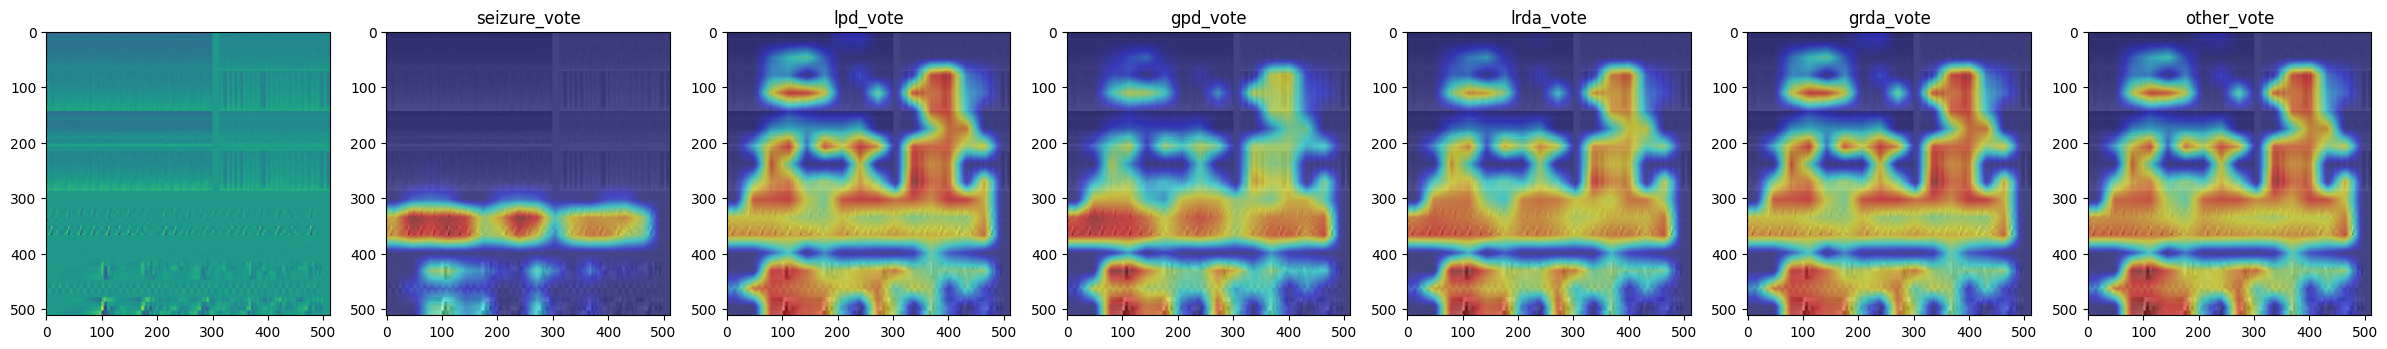

In [83]:
num_samples = 5
for i in range(num_samples):
    sample_idx = torch.randint(0, len(val_dataset), (1,)).item()
    display_sample(sample_idx)